# PCA

In [1]:
! pip install --quiet --upgrade nltk > /dev/null

In [2]:
# make a tag for this run
import datetime
import os

# Process the sentences
import re
import string
import warnings

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, KMeans

# importing libraries to use
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

from project_utilities import upload_to_s3

nltk.download("all", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

True

In [3]:
# Identify the working directory and data files
working_directory = "33-PCA-TSNE-KMeans-DBSCAN"

# Create the working directory if needed
try:
    os.makedirs(working_directory, exist_ok=True)
except OSError as error:
    print(f"Error creating {working_directory}: {error}")

In [4]:
df = pd.read_pickle("./21-Preprocess-Combined-Data-v2/dataframe.pickle")

In [5]:
verification_row = 9
n_components = 25

In [6]:
TAG = f"{datetime.datetime.now():%Y_%m_%d_%s}"

In [7]:
scores = {}

In [8]:
df.shape

(5736, 20)

In [9]:
df.head()

ROW_ID                                           FOI_TEXT   
0  1969025  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...  \
1  1426265  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
2  2609625  IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...   
3  2813837  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
4  1337517  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   

  DEVICE_PROBLEM_CODE             DEVICE_PROBLEM_TEXT   
0                3283  Wireless Communication Problem  \
1                3283  Wireless Communication Problem   
2                1435                No Device Output   
3                3283  Wireless Communication Problem   
4                3283  Wireless Communication Problem   

                 GENERIC_NAME DEVICE_REPORT_PRODUCT_CODE          UDI-DI   
0  CONTINUOUS GLUCOSE MONITOR                        QBJ                  \
1  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
2  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
3  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
4  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   

       UDI-PUBLIC DATE_OF_EVENT REPORTER_OCCUPATION_CODE REPORT_DATE   
0                    07/30/2020                      000              \
1  00386270000385    06/05/2020                      000               
2  00386270000385    10/05/2020                      000               
3  00386270000385    10/23/2020                      000               
4  00386270000385    05/25/2020                      000               

  EVENT_LOCATION SOURCE_TYPE   
0              I    CONSUMER  \
1              I    CONSUMER   
2              I    CONSUMER   
3              I    CONSUMER   
4              I    CONSUMER   

                                      TOKENIZED_TEXT   
0  [it, was, reported, that, the, transmitter, lo...  \
1  [it, was, reported, that, signal, loss, over, ...   
2  [it, was, reported, that, transmitter, failed,...   
3  [it, was, reported, that, signal, loss, over, ...   
4  [it, was, reported, that, signal, loss, over, ...   

                                        NOPUNCT_TEXT   
0  [it, was, reported, that, the, transmitter, lo...  \
1  [it, was, reported, that, signal, loss, over, ...   
2  [it, was, reported, that, transmitter, failed,...   
3  [it, was, reported, that, signal, loss, over, ...   
4  [it, was, reported, that, signal, loss, over, ...   

                                    NOSTOPWORDS_TEXT   
0  [reported, transmitter, lost, connection, pump...  \
1  [reported, signal, loss, one, hour, occurred, ...   
2  [reported, transmitter, failed, error, occurre...   
3  [reported, signal, loss, one, hour, occurred, ...   
4  [reported, signal, loss, one, hour, occurred, ...   

                                       NODIGITS_TEXT   
0  [reported, transmitter, lost, connection, pump...  \
1  [reported, signal, loss, one, hour, occurred, ...   
2  [reported, transmitter, failed, error, occurre...   
3  [reported, signal, loss, one, hour, occurred, ...   
4  [reported, signal, loss, one, hour, occurred, ...   

                                            POS_TEXT   
0  [(reported, VBN), (transmitter, NN), (lost, VB...  \
1  [(reported, VBN), (signal, JJ), (loss, NN), (o...   
2  [(reported, VBN), (transmitter, NN), (failed, ...   
3  [(reported, VBN), (signal, JJ), (loss, NN), (o...   
4  [(reported, VBN), (signal, JJ), (loss, NN), (o...   

                                     LEMMATIZED_TEXT   
0  [report, transmitter, lose, connection, pump, ...  \
1  [report, signal, loss, one, hour, occur, produ...   
2  [report, transmitter, fail, error, occur, data...   
3  [report, signal, loss, one, hour, occur, revie...   
4  [report, signal, loss, one, hour, occur, produ...   

                                        STEMMED_TEXT  
0  [report, transmitt, lost, connect, pump, great...  
1  [report, signal, loss, one, hour, occur, produ...  


In [10]:
# create a DataFrame for the sentences
sentences_df = pd.DataFrame(
    columns=[
        "SENTENCE_ID",
        "SENTENCE",
        "ROW_ID",
        "FOI_TEXT",
        "DEVICE_PROBLEM_CODE",
        "DEVICE_PROBLEM_TEXT",
    ]
)

# Iterate over every row in the FOI_TEXT DataFrame
# and create a new dataframe with a row for each sentence.
# Each row will have a sentence, the orginal ROW_ID, and the
# FOI_TEXT that it came from along with the DEVICE_PROBLEM_CODE and
# DEVICE_PROBLEM_TEXT from the orginal FOI_TEXT
sentence_counter = 0

for index, row in df.iterrows():
    for sentence in nltk.sent_tokenize(row["FOI_TEXT"]):
        sentence_data = {
            "SENTENCE": sentence,
            "SENTENCE_ID": sentence_counter,
            "ROW_ID": row["ROW_ID"],
            "FOI_TEXT": row["FOI_TEXT"],
            "DEVICE_PROBLEM_CODE": row["DEVICE_PROBLEM_CODE"],
            "DEVICE_PROBLEM_TEXT": row["DEVICE_PROBLEM_TEXT"],
        }
        sentence_data_df = pd.DataFrame(sentence_data, index=[sentence_counter])
        sentences_df = pd.concat([sentences_df, sentence_data_df])
        sentence_counter = sentence_counter + 1

In [11]:
sentences_df.shape

(25686, 6)

In [12]:
sentences_df.head()

SENTENCE_ID                                           SENTENCE   ROW_ID   
0           0  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...  1969025  \
1           1  THE TRANSMITTER ULTIMATELY REGAINED CONNECTION...  1969025   
2           2  NO ADDITIONAL PATIENT OR EVENT INFORMATION WAS...  1969025   
3           3  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...  1426265   
4           4    NO PRODUCT OR DATA WAS PROVIDED FOR EVALUATION.  1426265   

                                            FOI_TEXT DEVICE_PROBLEM_CODE   
0  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...                3283  \
1  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...                3283   
2  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...                3283   
3  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...                3283   
4  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...                3283   

              DEVICE_PROBLEM_TEXT  
0  Wireless Communication Problem  
1  Wireless Communication Problem  
2  Wireless Communication Problem  
3  Wireless Communication Problem  
4  Wireless Communication Problem

In [13]:
sentences_df["SENTENCE"][verification_row]

'THE PROBABLE CAUSE COULD NOT BE DETERMINED.'

In [14]:
stop_words = set(stopwords.words("english"))
punctuations = set(string.punctuation)


def process_sentence(sentence):
    # Lowercase the sentence
    sentence = sentence.lower()

    # Remove any words that start with a digit
    sentence = re.sub(r"\b\d\w*\b", "", sentence)

    # Remove punctuation
    sentence_tokens = sentence.split()
    sentence_tokens = [
        token.translate(str.maketrans("", "", string.punctuation))
        for token in sentence_tokens
    ]

    # Remove stopwords
    sentence_tokens = [token for token in sentence_tokens if token not in stop_words]
    sentence = " ".join(sentence_tokens)

    return sentence


sentences_df["PROCESSED_SENTENCE"] = sentences_df["SENTENCE"].apply(process_sentence)

In [15]:
sentences_df["PROCESSED_SENTENCE"][verification_row]

'probable cause could determined'

In [16]:
%pip install --upgrade --quiet sentence-transformers hdbscan mpld3 sentence_transformers

Note: you may need to restart the kernel to use updated packages.


In [17]:
# define the document embedding model
# https://www.sbert.net/docs/pretrained_models.html
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embedded_sentences = embedder.encode(sentences_df["PROCESSED_SENTENCE"])
embedded_sentences

array([[ 0.00797196,  0.06402367,  0.01412312, ...,  0.01263442,
        -0.0927747 , -0.04012575],
       [-0.02872899,  0.01099845,  0.0145125 , ...,  0.03422186,
        -0.02442272, -0.04160523],
       [ 0.00838429,  0.05963192, -0.03641192, ...,  0.03092053,
        -0.00812466, -0.00493952],
       ...,
       [-0.06312982,  0.09404119, -0.02415265, ..., -0.01254776,
         0.10541871,  0.04489084],
       [ 0.00619845, -0.013316  ,  0.0515376 , ..., -0.06092132,
         0.0018618 , -0.06808808],
       [ 0.03530982,  0.0642552 ,  0.06098982, ..., -0.06081245,
         0.06142467,  0.04099736]], dtype=float32)

In [18]:
scaler = MinMaxScaler()

# "np.array([i for i in df['EMBED']])" Converts the data into a 2d array
embedded_sentences_scaled = scaler.fit_transform(
    np.array([i for i in embedded_sentences])
)

In [19]:
embedded_sentences_scaled

array([[0.5719787 , 0.6762023 , 0.48890775, ..., 0.55340767, 0.36013076,
        0.40519148],
       [0.41584435, 0.4543546 , 0.49014112, ..., 0.6189094 , 0.5331781 ,
        0.40002674],
       [0.57373285, 0.65782803, 0.32883412, ..., 0.6088924 , 0.57444006,
        0.5280243 ],
       ...,
       [0.2694953 , 0.80179006, 0.3676663 , ..., 0.4769985 , 0.86189884,
        0.7019789 ],
       [0.56443375, 0.3526275 , 0.607421  , ..., 0.33022088, 0.59972286,
        0.30757684],
       [0.6882802 , 0.677171  , 0.63736165, ..., 0.3305512 , 0.75051874,
        0.688387  ]], dtype=float32)

In [20]:
# Vectorize the sentences using TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorized_sentences = vectorizer.fit_transform(sentences_df["PROCESSED_SENTENCE"])
vectorized_sentences

<25686x1050 sparse matrix of type '<class 'numpy.float64'>'
	with 134036 stored elements in Compressed Sparse Row format>

In [21]:
# Combine the embeddings and vectorized sentences into a single feature matrix
feature_matrix = pd.concat(
    [
        pd.DataFrame(embedded_sentences_scaled),
        pd.DataFrame(vectorized_sentences.toarray()),
    ],
    axis=1,
)

In [22]:
feature_matrix.shape

(25686, 1434)

In [23]:
warnings.filterwarnings("ignore")

In [24]:
# Performing PCA with 10 components
pca = PCA(n_components=10)

# applying pca on the data
pca.fit(feature_matrix)

# getting pca components
pca_components = pca.fit_transform(feature_matrix)

# getting explained variance ratio
explained_var = pca.explained_variance_ratio_

# making components
components = ["PC" + str(i) for i in range(1, len(explained_var) + 1)]

# Creating a dataframe of the explained variance ratio for each component
ev_df = pd.DataFrame(
    {"Component": components, "Explained Variance Ratio": explained_var}
)
ev_df = ev_df.sort_values(by="Explained Variance Ratio", ascending=False)

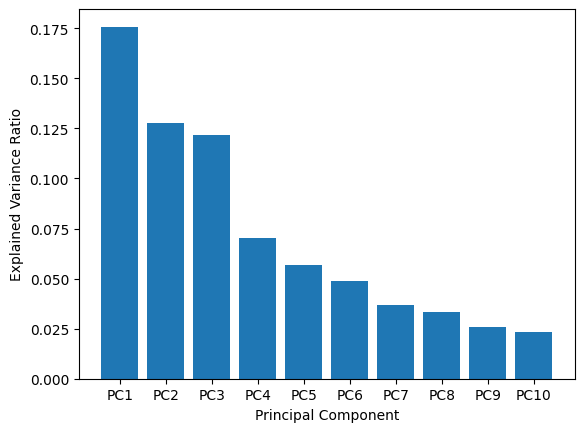

In [25]:
# Ploting the explained variance ratio for each component
plt.bar(ev_df["Component"], ev_df["Explained Variance Ratio"])
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

Text(0, 0.5, 'Explained Variance')

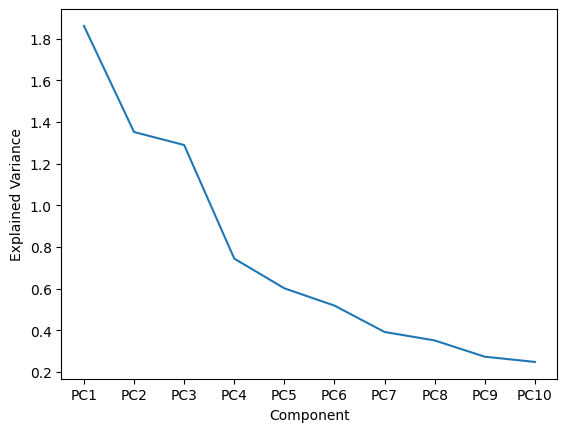

In [26]:
# making a line chart to visualize the explained variance
components_name = ev_df["Component"]
sns.lineplot(x=components_name, y=pca.explained_variance_)
plt.ylabel("Explained Variance")

In [27]:
# Calculate the total explained variance
total_explained_variance = sum(pca.explained_variance_)

print(f"Total explained variance: {total_explained_variance*10:.4f}")

Total explained variance: 76.3063


In [28]:
cumulative_explained_variance_df = pd.DataFrame(
    {
        "Number of Components": range(1, len(np.cumsum(pca.explained_variance_)) + 1),
        "Cumulative Explained Variance": np.cumsum(
            np.round(pca.explained_variance_ratio_, decimals=3) * 100
        ),
    }
)

cumulative_explained_variance_df

Number of Components  Cumulative Explained Variance
0                     1                           17.6
1                     2                           30.4
2                     3                           42.6
3                     4                           49.6
4                     5                           55.3
5                     6                           60.2
6                     7                           63.9
7                     8                           67.2
8                     9                           69.8
9                    10                           72.1

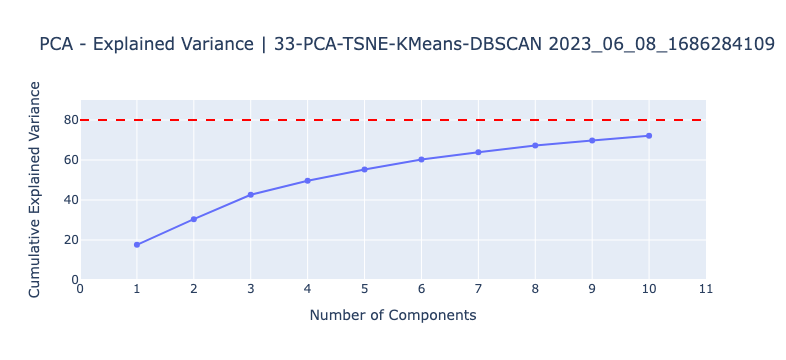

In [29]:
fig_1 = px.line(
    cumulative_explained_variance_df,
    x="Number of Components",
    y="Cumulative Explained Variance",
    title=f"PCA - Explained Variance | {working_directory} {TAG}\n",
)

# add markers for each point
fig_1.update_traces(mode="lines+markers")

# extend the limits of the y-axis from 0 to 90
fig_1.update_yaxes(range=[0, 90])

# extend the limits of the x-axis from 0 to 16
fig_1.update_xaxes(range=[0, 11])

# add a horizontal rule for y = 80
fig_1.add_shape(
    type="line", x0=0, y0=80, x1=27, y1=80, line=dict(color="red", width=2, dash="dash")
)

# show all numbers on the x-axis
fig_1.update_layout(xaxis=dict(tickmode="linear"))

# write the graph to a file in the working directory
fig_1.write_html(
    f"{working_directory}/pca_explained_variance_with_{n_components}_components_{TAG}.html"
)

# show the plot
fig_1.show()

In [30]:
# Choosing the  3 principal components
pca = PCA(n_components=3)

# applying on data
pca.fit(feature_matrix)

# converting data
pca_df = pd.DataFrame(pca.transform(feature_matrix), columns=["PC1", "PC2", "PC3"])

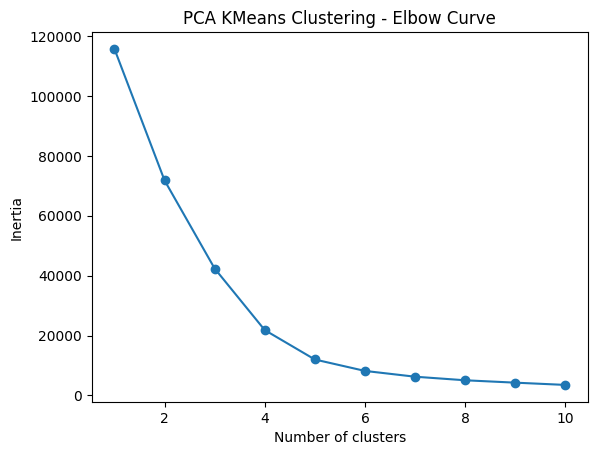

In [31]:
# making an empty list to store inertia for each cluster
inertias = []

# Performing KMeans clustering with 1 to 10 clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertias.append(kmeans.inertia_)

# Ploting the elbow curve
plt.plot(range(1, 11), inertias, marker="o")
plt.title("PCA KMeans Clustering - Elbow Curve")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

- After 5 clusters the change in inertia is not significant

# PCA KMeans Clustering

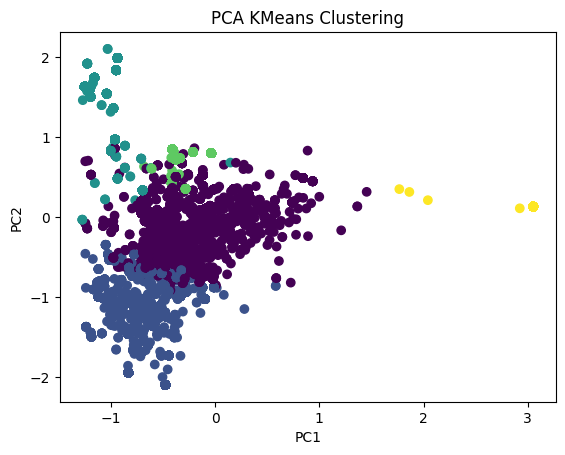

In [32]:
# Choose the number of clusters based on the elbow method
kmeans = KMeans(n_clusters=5, random_state=42)

# applying the kmeans clustering on the dataset obtained after applying pca for 3 components
kmeans.fit(pca_df)

# getting labels
y_pred_pca = kmeans.fit_predict(pca_df)
kmeans_labels = kmeans.labels_

# Visualize the clustering results in 2D using the first two principal components
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=kmeans_labels)
plt.title("PCA KMeans Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

- Silhouette Score is a measure of how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1. A score of 1 indicates that the object is perfectly matched to its own cluster, and a score of -1 indicates that the object is better matched to a different cluster.

In [33]:
# Compute the silhouette score
score = silhouette_score(pca_df, y_pred_pca)
scores["PCA KMeans Clustering"] = score

print("Silhouette Score for PCA KMeans Clustering: ", score)

Silhouette Score for PCA KMeans Clustering:  0.6229034202919946


In [34]:
# adding cluster labels to the sentence df
sentences_df["PCA_CLUSTER"] = kmeans_labels

# PCA DBSCAN Clustering

In [35]:
eps = [0.75, 0.5, 0.31, 0.31, 0.75, 1, 1, 0.5, 2, 2, 3, 3]
min_samples = [2, 2, 2, 4, 4, 2, 4, 4, 2, 4, 2, 4]

dbscan_pca_collection = []
dbscan_pca_labels_collection = []

for i in range(0, len(eps)):
    # Performing DBSCAN clustering
    dbscan_pca_collection.append(DBSCAN(eps=eps[i], min_samples=min_samples[i]))

    # getting labels for components obtained after applying pca
    dbscan_pca_labels_collection.append(dbscan_pca_collection[i].fit_predict(pca_df))

    # adding cluster labels to the sentence df
    sentences_df[
        f"PCA_DBSCAN_CLUSTER_{eps[i]}_{min_samples[i]}"
    ] = dbscan_pca_labels_collection[i]

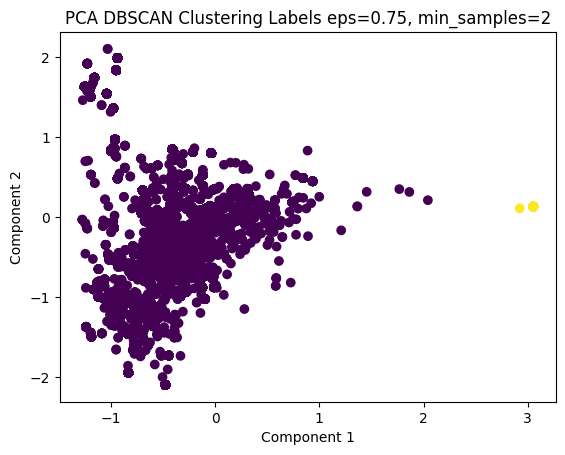

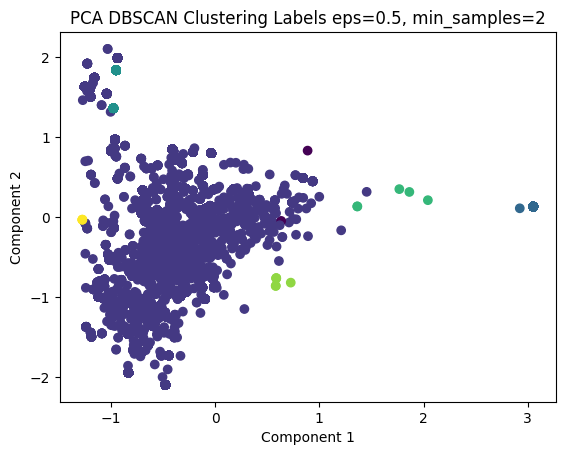

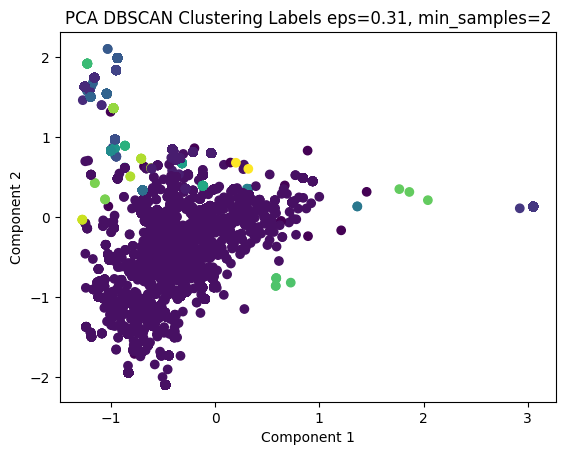

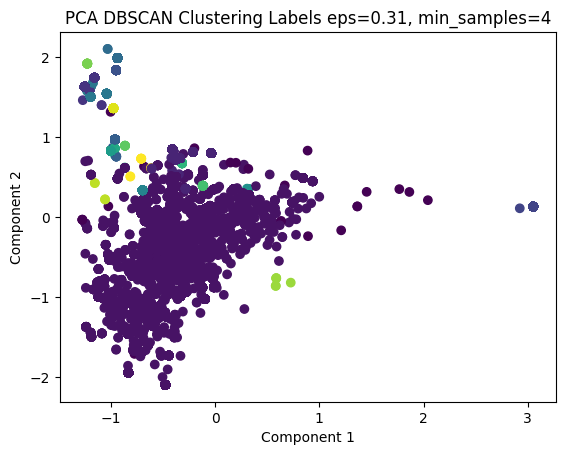

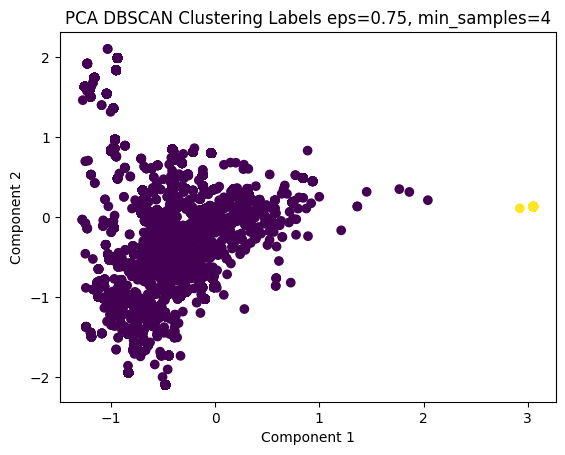

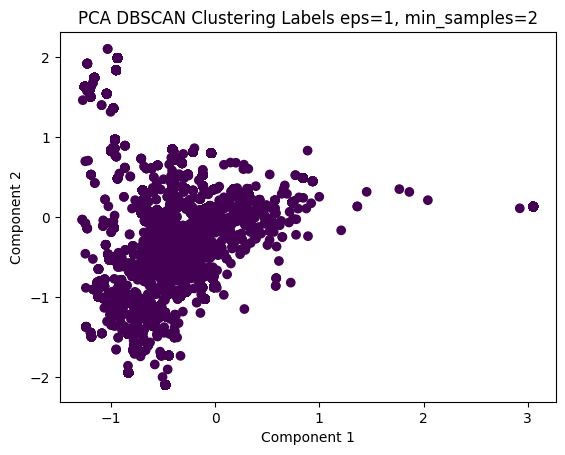

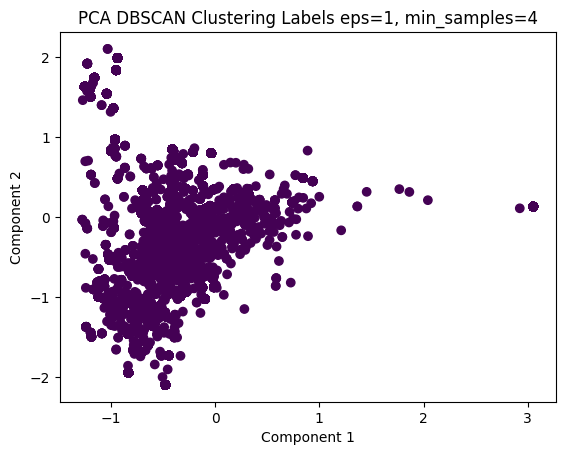

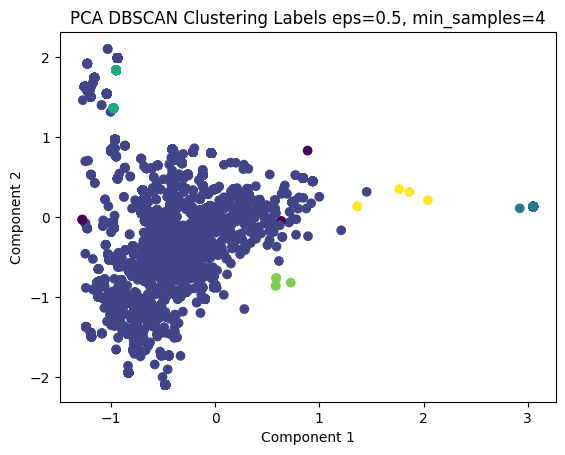

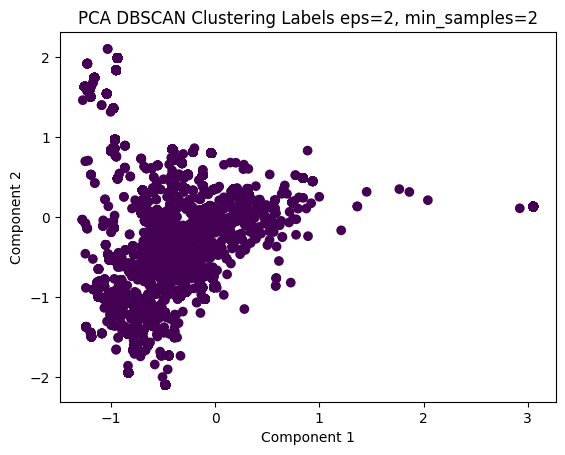

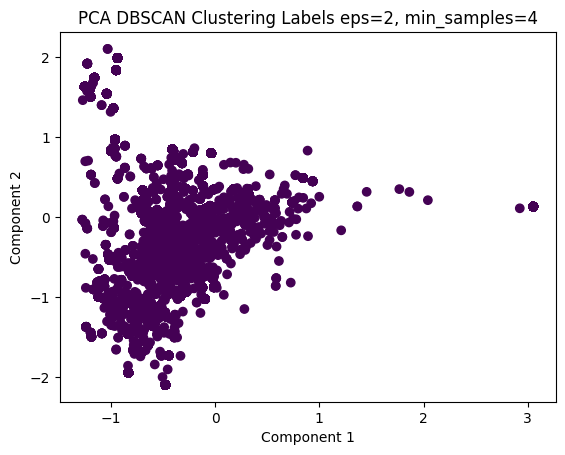

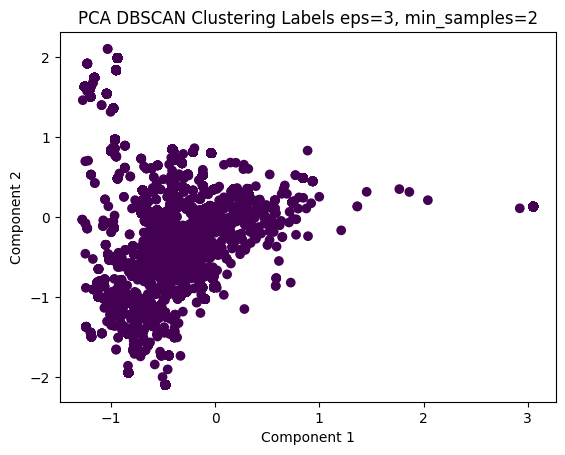

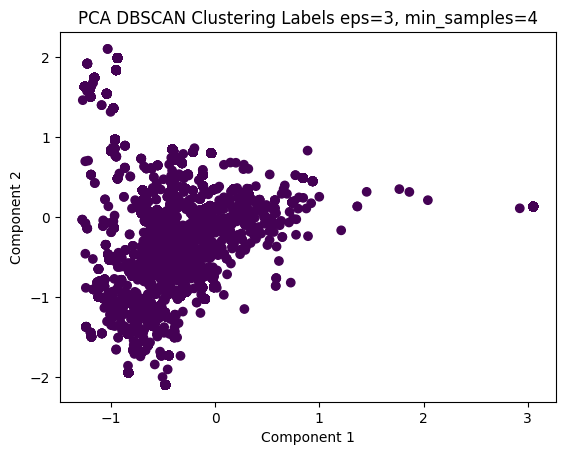

In [36]:
for i in range(0, len(eps)):
    # Plotting PCA visualization with DBSCAN labels
    plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], c=dbscan_pca_labels_collection[i])
    plt.title(
        f"PCA DBSCAN Clustering Labels eps={eps[i]}, min_samples={min_samples[i]}"
    )
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

In [37]:
score_fail = []

# Try to compute the silhouette score for each combination of eps and min_samples
for i in range(0, len(eps)):
    try:
        score = silhouette_score(pca_df, dbscan_pca_labels_collection[i])
    except ValueError as e:
        print(
            f"Silhouette Score for PCA DBSCAN Clustering eps={eps[i]}, min_samples={min_samples[i]}: -"
        )
        note = f"Can't compute Silhouette Score for PCA DBSCAN Clustering eps={eps[i]}, min_samples={min_samples[i]}: {e}"
        score_fail.append(note)
        continue

    scores[f"PCA DBSCAN Clustering eps={eps[i]}, min_samples={min_samples[i]}"] = score
    print(
        f"Silhouette Score for PCA DBSCAN Clustering eps={eps[i]}, min_samples={min_samples[i]}: {score}"
    )

Silhouette Score for PCA DBSCAN Clustering eps=0.75, min_samples=2: 0.5165822836217289
Silhouette Score for PCA DBSCAN Clustering eps=0.5, min_samples=2: -0.027840769992677386
Silhouette Score for PCA DBSCAN Clustering eps=0.31, min_samples=2: 0.3902810761256614
Silhouette Score for PCA DBSCAN Clustering eps=0.31, min_samples=4: 0.4331891110164052
Silhouette Score for PCA DBSCAN Clustering eps=0.75, min_samples=4: 0.5165822836217289
Silhouette Score for PCA DBSCAN Clustering eps=1, min_samples=2: -
Silhouette Score for PCA DBSCAN Clustering eps=1, min_samples=4: -
Silhouette Score for PCA DBSCAN Clustering eps=0.5, min_samples=4: 0.033463823836456526
Silhouette Score for PCA DBSCAN Clustering eps=2, min_samples=2: -
Silhouette Score for PCA DBSCAN Clustering eps=2, min_samples=4: -
Silhouette Score for PCA DBSCAN Clustering eps=3, min_samples=2: -
Silhouette Score for PCA DBSCAN Clustering eps=3, min_samples=4: -


In [38]:
# Report any failed score attempts
for i in range(0, len(score_fail)):
    print(score_fail[i])

Can't compute Silhouette Score for PCA DBSCAN Clustering eps=1, min_samples=2: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=1, min_samples=4: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=2, min_samples=2: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=2, min_samples=4: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=3, min_samples=2: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=3, min_samples=4: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


## Summary

In [39]:
scores_df = pd.DataFrame.from_dict(scores, orient="index", columns=["Value"])
scores_df.sort_values(by="Value", ascending=False)

Value
PCA KMeans Clustering                          0.622903
PCA DBSCAN Clustering eps=0.75, min_samples=2  0.516582
PCA DBSCAN Clustering eps=0.75, min_samples=4  0.516582
PCA DBSCAN Clustering eps=0.31, min_samples=4  0.433189
PCA DBSCAN Clustering eps=0.31, min_samples=2  0.390281
PCA DBSCAN Clustering eps=0.5, min_samples=4   0.033464
PCA DBSCAN Clustering eps=0.5, min_samples=2  -0.027841

In [40]:
print(f"Largest value is {scores_df.loc[scores_df['Value'].idxmax()]}")

Largest value is Value    0.622903
Name: PCA KMeans Clustering, dtype: float64


In [41]:
# Write the sentences dataframe to a CSV file
sentences_df.to_csv(f"{working_directory}/sentences_dataframe_{TAG}.csv", index=False)

# Write the sentences dataframe to a pickle
sentences_df.to_pickle(f"{working_directory}/sentences_dataframe_{TAG}.pickle")